In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import os
from torchvision import datasets, transforms
from torch import optim, nn, unsqueeze
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Grayscale(num_output_channels=1)])

# Download and load the training data
trainset0 = datasets.ImageFolder('mnist-varres/train', transform=transform)
testset = datasets.ImageFolder('mnist-varres/test', transform=transform)

In [3]:
# Divide data in the three resolutions

train_res_1 = []
train_res_2 = []
train_res_3 = []

test_res_1 = []
test_res_2 = []
test_res_3 = []

for item in trainset0: 
    if item[0].shape[1] == 32: train_res_1.append(item)
    elif item[0].shape[1] == 48: train_res_2.append(item)
    elif item[0].shape[1] == 64: train_res_3.append(item)
        
for item in testset: 
    if item[0].shape[1] == 32: test_res_1.append(item)
    elif item[0].shape[1] == 48: test_res_2.append(item)
    elif item[0].shape[1] == 64: test_res_3.append(item)

In [4]:
batch_size = 16

# Also create a validation set 

trainset_1, valset_1 = train_test_split(train_res_1, test_size=0.9, random_state=42)
trainset_2, valset_2 = train_test_split(train_res_2, test_size=0.9, random_state=42)
trainset_3, valset_3 = train_test_split(train_res_3, test_size=0.9, random_state=42)

# Resoluted Training Set

trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Validation Set

valloader_1 = torch.utils.data.DataLoader(valset_1, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_2 = torch.utils.data.DataLoader(valset_2, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_3 = torch.utils.data.DataLoader(valset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Test Set

testloader_1 = torch.utils.data.DataLoader(test_res_1, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_2 = torch.utils.data.DataLoader(test_res_2, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_3 = torch.utils.data.DataLoader(test_res_3, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
training_data = enumerate(trainloader_1)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([16, 1, 32, 32])
torch.Size([16])


In [6]:
import torch.nn.functional as F

N = 81

class Network(nn.Module):

    def __init__(self, mean_pooling):
        
        self.mean_pooling = mean_pooling
        
        super(Network, self).__init__()

        self.conv_neural_network_layers = nn.Sequential(
                
                # first conv layer
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),                
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
            
                # second conv layer
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),

                # second conv layer
                nn.Conv2d(in_channels=32, out_channels=N, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2))

        #linear layer
        self.linear_layers = nn.Sequential(
                nn.Linear(N, 10))

    # Defining the forward pass 
    def forward(self, x):
        x = self.conv_neural_network_layers(x)

        #global max pooling
        if self.mean_pooling:
            x = torch.flatten(F.adaptive_avg_pool2d(x, (1, 1)), 1)
        
        else:
            x = torch.flatten(F.adaptive_max_pool2d(x, (1, 1)), 1)
        
        #linear layer
        x = self.linear_layers(x)
        
        return x
    

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y_hot = F.one_hot(y, 10)
        y_hot = torch.zeros(X.shape[0], 10)
        y_hot[range(y_hot.shape[0]), y]=1      

        X, y_hot = X.to(device), y_hot.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y_hot)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return loss


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        y_hot = F.one_hot(y, 10)
        y_hot = torch.zeros(X.shape[0], 10)
        y_hot[range(y_hot.shape[0]), y]=1      

        X, y_hot = X.to(device), y_hot.to(device)

        # Compute prediction error
        pred = model(X)
        test_loss += loss_fn(pred, y_hot).item()
        correct += (pred.argmax(axis=1) == y_hot.argmax(axis=1)).type(torch.float).sum().item()

    test_loss /= 10000
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

## Experiments

In [7]:
epochs = 5

model_mean_pooling = Network(mean_pooling=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_mean_pooling.parameters(), lr=1e-3)


train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]

In [9]:
#number of parameters from previous (fixed resolution network) is 29066. 
#for this network: N=81 comes the closest (29029) --> 
#N=81 is used in the following experiments.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("Number of parameters: ", count_parameters(model_mean_pooling))

Number of parameters:  29029


### Q16

In [10]:
# Training Loop with Nested Loop

#First, global mean pooling vs global max pooling
#Global mean pooling
mmp_train_loss_1 = []
mmp_train_loss_2 = []
mmp_train_loss_3 = []

mmp_loss_1 = []
mmp_loss_2 = []
mmp_loss_3 = []

mmp_acc_1 = []
mmp_acc_2 = []
mmp_acc_3 = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_mean_pooling, loss_fn, optimizer)
        globals()['mmp_train_loss_'+str(i+1)].append(train_loss)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_mean_pooling, loss_fn)
        globals()['mmp_loss_'+str(i+1)].append(loss)
        globals()['mmp_acc_'+str(i+1)].append(acc)

    
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 12.7%, Avg loss: 0.045217 

Test Error: 
 Accuracy: 13.7%, Avg loss: 0.036598 

Test Error: 
 Accuracy: 19.1%, Avg loss: 0.035974 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 13.9%, Avg loss: 0.209218 

Test Error: 
 Accuracy: 22.1%, Avg loss: 0.045195 

Test Error: 
 Accuracy: 28.8%, Avg loss: 0.031284 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 27.1%, Avg loss: 0.121351 

Test Error: 
 Accuracy: 37.3%, Avg loss: 0.033735 

Test Error: 
 Accuracy: 50.9%, Avg loss: 0.027928 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 38.3%, Avg loss: 0.086936 

Test Error: 
 Accuracy: 63.1%, Avg loss: 0.023750 

Test Error: 
 Accuracy: 71.3%, Avg loss: 0.021595 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 40.6%, Avg loss: 0.075884 

Test Error: 
 Accuracy: 66.6%, Avg loss: 0.021553 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.017891 

Done!


In [11]:
# Calculate average loss for all resolutions
mmp_train_loss_1 = [loss.detach().numpy() for loss in mmp_train_loss_1]
mmp_train_loss_2 = [loss.detach().numpy() for loss in mmp_train_loss_2]
mmp_train_loss_3 = [loss.detach().numpy() for loss in mmp_train_loss_3]

mmp_train_loss_avg = np.array([mmp_train_loss_1, mmp_train_loss_2, mmp_train_loss_3]).mean(axis=0)
mmp_loss_avg = np.array([mmp_loss_1, mmp_loss_2, mmp_loss_3]).mean(axis=0)
mmp_acc_avg = np.array([mmp_acc_1, mmp_acc_2, mmp_acc_3]).mean(axis=0)

In [12]:
mmp_train_loss_3

[array(0.3142371, dtype=float32),
 array(0.2902183, dtype=float32),
 array(0.24270475, dtype=float32),
 array(0.18338884, dtype=float32),
 array(0.14279537, dtype=float32)]

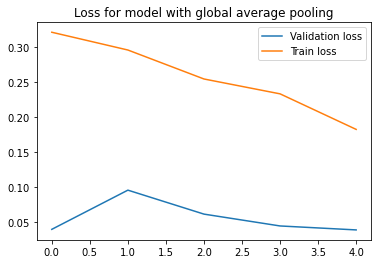

In [13]:
plt.plot(mmp_loss_avg, label="Validation loss")
plt.plot(mmp_train_loss_avg, label="Train loss")
plt.title("Loss for model with global average pooling")
plt.legend()

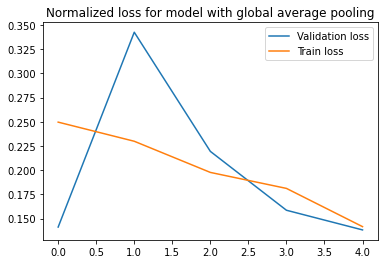

In [14]:
#normalize the curves to see the behavior of the validation loss better
normed_mmp_train_losses = [i/sum(mmp_train_loss_avg) for i in mmp_train_loss_avg]
normed_mmp_val_losses = [i/sum(mmp_loss_avg) for i in mmp_loss_avg]

plt.plot(normed_mmp_val_losses, label="Validation loss")
plt.plot(normed_mmp_train_losses, label="Train loss")
plt.title("Normalized loss for model with global average pooling")
plt.legend()

In [15]:
#Global max pooling
epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-3)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]

In [16]:
mmxp_train_loss_1 = []
mmxp_train_loss_2 = []
mmxp_train_loss_3 = []

mmxp_loss_1 = []
mmxp_loss_2 = []
mmxp_loss_3 = []

mmxp_acc_1 = []
mmxp_acc_2 = []
mmxp_acc_3 = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
        globals()['mmxp_train_loss_'+str(i+1)].append(train_loss)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
        globals()['mmxp_loss_'+str(i+1)].append(loss)
        globals()['mmxp_acc_'+str(i+1)].append(acc)

    
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.012004 

Test Error: 
 Accuracy: 83.1%, Avg loss: 0.012050 

Test Error: 
 Accuracy: 83.1%, Avg loss: 0.011949 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.004891 

Test Error: 
 Accuracy: 94.7%, Avg loss: 0.004920 

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.004937 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.003866 

Test Error: 
 Accuracy: 95.8%, Avg loss: 0.003940 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.004011 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.003566 

Test Error: 
 Accuracy: 96.2%, Avg loss: 0.003450 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003511 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.002867 

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.003016 

Test Error: 
 Accuracy: 96.6%, Avg loss: 0.003084 

Done!


In [17]:
#Calculate average loss for all resolutions
mmxp_train_loss_1 = [loss.detach().numpy() for loss in mmxp_train_loss_1]
mmxp_train_loss_2 = [loss.detach().numpy() for loss in mmxp_train_loss_2]
mmxp_train_loss_3 = [loss.detach().numpy() for loss in mmxp_train_loss_3]

mmxp_train_loss_avg = np.array([mmxp_train_loss_1, mmxp_train_loss_2, mmxp_train_loss_3]).mean(axis=0)
mmxp_loss_avg = np.array([mmxp_loss_1, mmxp_loss_2, mmxp_loss_3]).mean(axis=0)
mmxp_acc_avg = np.array([mmxp_acc_1, mmxp_acc_2, mmxp_acc_3]).mean(axis=0)

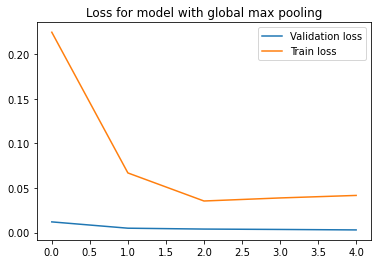

In [18]:
plt.plot(mmxp_loss_avg, label="Validation loss")
plt.plot(mmxp_train_loss_avg, label="Train loss")
plt.title("Loss for model with global max pooling")
plt.legend()

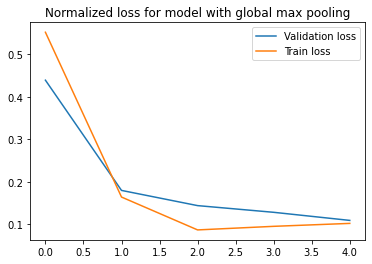

In [19]:
#normalize the curves to see the behavior of the validation loss better
normed_mmxp_train_losses = [i/sum(mmxp_train_loss_avg) for i in mmxp_train_loss_avg]
normed_mmxp_val_losses = [i/sum(mmxp_loss_avg) for i in mmxp_loss_avg]

plt.plot(normed_mmxp_val_losses, label="Validation loss")
plt.plot(normed_mmxp_train_losses, label="Train loss")
plt.title("Normalized loss for model with global max pooling")
plt.legend()

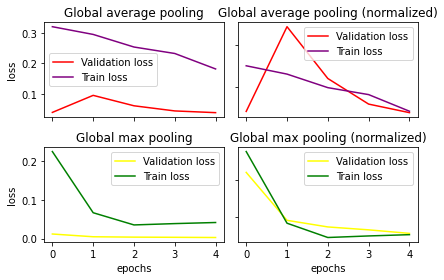

In [20]:
#plot all in one fig
fig, axs = plt.subplots(2, 2)

# mmp_train_losses = [loss.detach().numpy() for loss in mmp_train_loss]
# mmxp_train_losses = [loss.detach().numpy() for loss in mmxp_train_loss]

normed_mmp_train_losses = [i/sum(mmp_train_loss_avg) for i in mmp_train_loss_avg]
normed_mmp_val_losses = [i/sum(mmp_loss_avg) for i in mmp_loss_avg]

normed_mmxp_train_losses = [i/sum(mmxp_train_loss_avg) for i in mmxp_train_loss_avg]
normed_mmxp_val_losses = [i/sum(mmxp_loss_avg) for i in mmxp_loss_avg]

axs[0, 0].plot(mmp_loss_avg, label="Validation loss", color='red')
axs[0, 0].plot(mmp_train_loss_avg, label="Train loss", color='purple')
axs[0, 0].set_title("Global average pooling")
axs[0, 0].legend()

axs[0, 1].plot(normed_mmp_val_losses, label="Validation loss", color='red')
axs[0, 1].plot(normed_mmp_train_losses, label="Train loss", color='purple')
axs[0, 1].set_title("Global average pooling (normalized)")
axs[0, 1].legend()

axs[1, 0].plot(mmxp_loss_avg, label="Validation loss", color='yellow')
axs[1, 0].plot(mmxp_train_loss_avg, label="Train loss", color='green')
axs[1, 0].set_title("Global max pooling")
axs[1, 0].legend()

axs[1, 1].plot(normed_mmxp_val_losses, label="Validation loss", color='yellow')
axs[1, 1].plot(normed_mmxp_train_losses, label="Train loss", color='green')
axs[1, 1].set_title("Global max pooling (normalized)")
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.tight_layout()

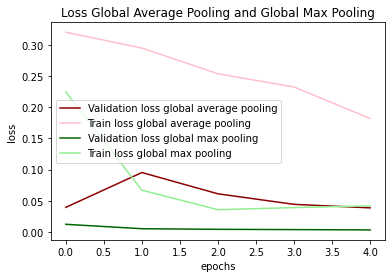

In [22]:
#both in the same figure
#plot all in one fig
# mmp_train_losses = [loss.detach().numpy() for loss in mmp_train_loss]
# mmxp_train_losses = [loss.detach().numpy() for loss in mmxp_train_loss]

# normed_mmp_train_losses = [i/sum(mmp_train_losses) for i in mmp_train_losses]
# normed_mmp_val_losses = [i/sum(mmp_loss) for i in mmp_loss]

# normed_mmxp_train_losses = [i/sum(mmxp_train_losses) for i in mmxp_train_losses]
# normed_mmxp_val_losses = [i/sum(mmxp_loss) for i in mmxp_loss]

plt.plot(mmp_loss_avg, label="Validation loss global average pooling", color='darkred')
plt.plot(mmp_train_loss_avg, label="Train loss global average pooling", color='pink')
plt.plot(mmxp_loss_avg, label="Validation loss global max pooling", color='darkgreen')
plt.plot(mmxp_train_loss_avg, label="Train loss global max pooling", color='lightgreen')
plt.title("Loss Global Average Pooling and Global Max Pooling")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


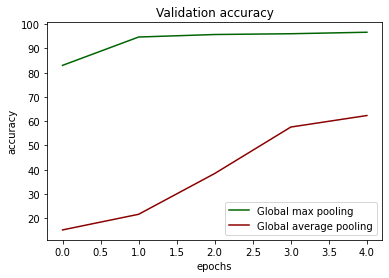

In [23]:
#accuracy plots
plt.plot(mmxp_acc_avg, label="Global max pooling", color = "darkgreen")
plt.plot(mmp_acc_avg, label="Global average pooling", color= "darkred")
plt.title("Validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

### Q17

In [ ]:
#Best pooling seems to be global max pooling -->
#This will be used for the next experiment

#Both networks will be tuned, first the one created in this notebook
#The hyperparameters: epochs, learning rate, batch size

In [24]:
#Epochs 5

epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-3)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.009898 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.009785 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.009786 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 93.7%, Avg loss: 0.005473 

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.005401 

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.005411 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.004500 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.004584 

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.004597 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.003838 

Test Error: 
 Accuracy: 95.9%, Avg loss: 0.003741 

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.003807 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.6%, Avg loss: 0.002965 

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.002945 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.003031 

Done!


In [25]:
#Epochs 10

epochs = 10

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-3)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.015660 

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.015784 

Test Error: 
 Accuracy: 77.2%, Avg loss: 0.015630 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 92.7%, Avg loss: 0.006673 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.006470 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.006412 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.004816 

Test Error: 
 Accuracy: 94.7%, Avg loss: 0.004612 

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.004653 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.003925 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003842 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003886 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.004636 

Test Error: 
 Accuracy: 95.1%, Avg loss: 0.004415 

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.004464 

Epoch 6
------------

In [26]:
#Learning rate 1e-2
epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-2)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 90.8%, Avg loss: 0.007691 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.007931 

Test Error: 
 Accuracy: 90.4%, Avg loss: 0.007827 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 93.7%, Avg loss: 0.005516 

Test Error: 
 Accuracy: 93.8%, Avg loss: 0.005651 

Test Error: 
 Accuracy: 93.6%, Avg loss: 0.005668 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.004493 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.004606 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.004545 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.004185 

Test Error: 
 Accuracy: 95.1%, Avg loss: 0.004245 

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.004271 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.003827 

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.003958 

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.003992 

Done!


In [27]:
#Learning rate 1e-3
epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-3)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.010135 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.010035 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.010000 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.005186 

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.005183 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005201 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.004189 

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.003913 

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.003997 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.003774 

Test Error: 
 Accuracy: 95.8%, Avg loss: 0.003841 

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.003917 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005089 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.004307 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.004407 

Done!


In [28]:
#Learning rate 1e-4
epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-4)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 30.8%, Avg loss: 0.036054 

Test Error: 
 Accuracy: 29.1%, Avg loss: 0.036368 

Test Error: 
 Accuracy: 29.9%, Avg loss: 0.036227 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 32.8%, Avg loss: 0.035024 

Test Error: 
 Accuracy: 30.5%, Avg loss: 0.035351 

Test Error: 
 Accuracy: 29.6%, Avg loss: 0.035229 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 48.8%, Avg loss: 0.031698 

Test Error: 
 Accuracy: 46.7%, Avg loss: 0.032065 

Test Error: 
 Accuracy: 47.7%, Avg loss: 0.031895 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 80.4%, Avg loss: 0.022384 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.022661 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.022535 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.014353 

Test Error: 
 Accuracy: 87.2%, Avg loss: 0.014615 

Test Error: 
 Accuracy: 87.7%, Avg loss: 0.014577 

Done!


In [29]:
#Learning rate 1e-5
epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-5)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.7%, Avg loss: 0.064158 

Test Error: 
 Accuracy: 10.0%, Avg loss: 0.064681 

Test Error: 
 Accuracy: 9.8%, Avg loss: 0.064469 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 9.7%, Avg loss: 0.040850 

Test Error: 
 Accuracy: 10.0%, Avg loss: 0.041169 

Test Error: 
 Accuracy: 9.8%, Avg loss: 0.041075 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 9.7%, Avg loss: 0.036775 

Test Error: 
 Accuracy: 10.0%, Avg loss: 0.037068 

Test Error: 
 Accuracy: 9.8%, Avg loss: 0.036969 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 9.7%, Avg loss: 0.036431 

Test Error: 
 Accuracy: 10.0%, Avg loss: 0.036730 

Test Error: 
 Accuracy: 9.8%, Avg loss: 0.036610 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 12.0%, Avg loss: 0.036281 

Test Error: 
 Accuracy: 11.6%, Avg loss: 0.036590 

Test Error: 
 Accuracy: 11.5%, Avg loss: 0.036459 

Done!


In [30]:
#Batch size 2

batch_size = 2

# Also create a validation set 

trainset_1, valset_1 = train_test_split(train_res_1, test_size=0.9, random_state=42)
trainset_2, valset_2 = train_test_split(train_res_2, test_size=0.9, random_state=42)
trainset_3, valset_3 = train_test_split(train_res_3, test_size=0.9, random_state=42)

# Resoluted Training Set

trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Validation Set

valloader_1 = torch.utils.data.DataLoader(valset_1, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_2 = torch.utils.data.DataLoader(valset_2, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_3 = torch.utils.data.DataLoader(valset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Test Set

testloader_1 = torch.utils.data.DataLoader(test_res_1, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_2 = torch.utils.data.DataLoader(test_res_2, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_3 = torch.utils.data.DataLoader(test_res_3, batch_size=batch_size, shuffle=True, num_workers=2)

epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-3)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.032179 

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.032680 

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.032989 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.022401 

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.022660 

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.022567 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.020637 

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.021428 

Test Error: 
 Accuracy: 96.9%, Avg loss: 0.021498 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.028309 

Test Error: 
 Accuracy: 96.2%, Avg loss: 0.031316 

Test Error: 
 Accuracy: 96.2%, Avg loss: 0.030659 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.020515 

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.021785 

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.022223 

Done!


In [31]:
#Batch size 4

#Batch size 2

batch_size = 4

# Also create a validation set 

trainset_1, valset_1 = train_test_split(train_res_1, test_size=0.9, random_state=42)
trainset_2, valset_2 = train_test_split(train_res_2, test_size=0.9, random_state=42)
trainset_3, valset_3 = train_test_split(train_res_3, test_size=0.9, random_state=42)

# Resoluted Training Set

trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Validation Set

valloader_1 = torch.utils.data.DataLoader(valset_1, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_2 = torch.utils.data.DataLoader(valset_2, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_3 = torch.utils.data.DataLoader(valset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Test Set

testloader_1 = torch.utils.data.DataLoader(test_res_1, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_2 = torch.utils.data.DataLoader(test_res_2, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_3 = torch.utils.data.DataLoader(test_res_3, batch_size=batch_size, shuffle=True, num_workers=2)

epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-3)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")




Epoch 1
-------------------------------
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.020801 

Test Error: 
 Accuracy: 94.2%, Avg loss: 0.019665 

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.019853 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.014789 

Test Error: 
 Accuracy: 96.1%, Avg loss: 0.014578 

Test Error: 
 Accuracy: 95.9%, Avg loss: 0.015045 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.011711 

Test Error: 
 Accuracy: 96.6%, Avg loss: 0.012068 

Test Error: 
 Accuracy: 96.6%, Avg loss: 0.012186 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.014479 

Test Error: 
 Accuracy: 95.8%, Avg loss: 0.015418 

Test Error: 
 Accuracy: 95.8%, Avg loss: 0.015934 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.015089 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.014832 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.015294 

Done!


In [32]:
#Batch size 8

#Batch size 2

batch_size = 8

# Also create a validation set 

trainset_1, valset_1 = train_test_split(train_res_1, test_size=0.9, random_state=42)
trainset_2, valset_2 = train_test_split(train_res_2, test_size=0.9, random_state=42)
trainset_3, valset_3 = train_test_split(train_res_3, test_size=0.9, random_state=42)

# Resoluted Training Set

trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Validation Set

valloader_1 = torch.utils.data.DataLoader(valset_1, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_2 = torch.utils.data.DataLoader(valset_2, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_3 = torch.utils.data.DataLoader(valset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Test Set

testloader_1 = torch.utils.data.DataLoader(test_res_1, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_2 = torch.utils.data.DataLoader(test_res_2, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_3 = torch.utils.data.DataLoader(test_res_3, batch_size=batch_size, shuffle=True, num_workers=2)

epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-3)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")



Epoch 1
-------------------------------
Test Error: 
 Accuracy: 94.2%, Avg loss: 0.010612 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.010352 

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.010658 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.009641 

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.008845 

Test Error: 
 Accuracy: 94.7%, Avg loss: 0.009232 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.007022 

Test Error: 
 Accuracy: 96.1%, Avg loss: 0.006932 

Test Error: 
 Accuracy: 96.1%, Avg loss: 0.007067 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.004853 

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.004574 

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.004865 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.005228 

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.005064 

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.005293 

Done!


In [33]:
#Batch size 16

#Batch size 2

batch_size = 16

# Also create a validation set 

trainset_1, valset_1 = train_test_split(train_res_1, test_size=0.9, random_state=42)
trainset_2, valset_2 = train_test_split(train_res_2, test_size=0.9, random_state=42)
trainset_3, valset_3 = train_test_split(train_res_3, test_size=0.9, random_state=42)

# Resoluted Training Set

trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Validation Set

valloader_1 = torch.utils.data.DataLoader(valset_1, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_2 = torch.utils.data.DataLoader(valset_2, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_3 = torch.utils.data.DataLoader(valset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Test Set

testloader_1 = torch.utils.data.DataLoader(test_res_1, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_2 = torch.utils.data.DataLoader(test_res_2, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_3 = torch.utils.data.DataLoader(test_res_3, batch_size=batch_size, shuffle=True, num_workers=2)

epochs = 5

model_max_pooling = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model_max_pooling.parameters(), lr=1e-3)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model_max_pooling, loss_fn, optimizer)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model_max_pooling, loss_fn)
    
print("Done!")



Epoch 1
-------------------------------
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.012279 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.011866 

Test Error: 
 Accuracy: 86.6%, Avg loss: 0.011747 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 92.6%, Avg loss: 0.006245 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.006622 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.006634 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.004562 

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.004695 

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.004756 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.003906 

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.004326 

Test Error: 
 Accuracy: 95.1%, Avg loss: 0.004420 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.003381 

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.003325 

Test Error: 
 Accuracy: 96.4%, Avg loss: 0.003291 

Done!


In [ ]:
#Optimal hyperparameters:
#Number of epochs: 10
#Learning rate: 1e-2
#Batch size: 2

In [40]:
#Now, we will run the optimized network on the test set

batch_size = 2

# Also create a validation set 

trainset_1, valset_1 = train_test_split(train_res_1, test_size=0.9, random_state=42)
trainset_2, valset_2 = train_test_split(train_res_2, test_size=0.9, random_state=42)
trainset_3, valset_3 = train_test_split(train_res_3, test_size=0.9, random_state=42)

# Resoluted Training Set

trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Validation Set

valloader_1 = torch.utils.data.DataLoader(valset_1, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_2 = torch.utils.data.DataLoader(valset_2, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_3 = torch.utils.data.DataLoader(valset_3, batch_size=batch_size, shuffle=True, num_workers=2)

# Resoluted Test Set

testloader_1 = torch.utils.data.DataLoader(test_res_1, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_2 = torch.utils.data.DataLoader(test_res_2, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_3 = torch.utils.data.DataLoader(test_res_3, batch_size=batch_size, shuffle=True, num_workers=2)

epochs = 10

model = Network(mean_pooling=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_res = [trainloader_1, trainloader_2, trainloader_3]
val_res = [valloader_1, valloader_2, valloader_3]
test_res = [testloader_1, testloader_2, testloader_3]

train_loss_1 = []
train_loss_2 = []
train_loss_3 = []

loss_1 = []
loss_2 = []
loss_3 = []

acc_1 = []
acc_2 = []
acc_3 = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Loop over three resolutions for training and validation/testing
    
    for i, res in enumerate(train_res):
        train_loss = train(res, model, loss_fn, optimizer)
        globals()['train_loss_'+str(i+1)].append(train_loss)
    
    for i, res in enumerate(val_res):
        loss, acc = test(res, model, loss_fn)
        globals()['loss_'+str(i+1)].append(loss)
        globals()['acc_'+str(i+1)].append(acc)

    
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.079290 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.081041 

Test Error: 
 Accuracy: 87.3%, Avg loss: 0.079924 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.063729 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.065470 

Test Error: 
 Accuracy: 90.6%, Avg loss: 0.065190 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.092800 

Test Error: 
 Accuracy: 86.9%, Avg loss: 0.099085 

Test Error: 
 Accuracy: 86.9%, Avg loss: 0.099036 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.077846 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.076376 

Test Error: 
 Accuracy: 88.3%, Avg loss: 0.077355 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.066954 

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.067727 

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.068111 

Epoch 6
------------

In [41]:
# Calculate average loss for all resolutions over validation and training data
train_loss_1 = [loss.detach().numpy() for loss in train_loss_1]
train_loss_2 = [loss.detach().numpy() for loss in train_loss_2]
train_loss_3 = [loss.detach().numpy() for loss in train_loss_3]

train_loss_avg = np.array([train_loss_1, train_loss_2, train_loss_3]).mean(axis=0)
loss_avg = np.array([loss_1, loss_2, loss_3]).mean(axis=0)
acc_avg = np.array([acc_1, acc_2, acc_3]).mean(axis=0)

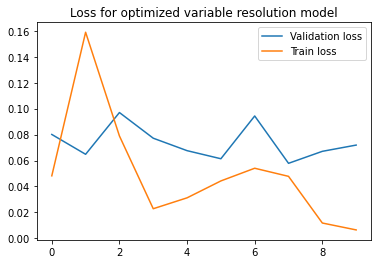

In [42]:
plt.plot(loss_avg, label="Validation loss")
plt.plot(train_loss_avg, label="Train loss")
plt.title("Loss for optimized variable resolution model")
plt.legend()

In [46]:
#final accuracy from final run over test set:
for i, res in enumerate(test_res):
    loss, acc = test(res, model, loss_fn)

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.011669 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.013387 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.012107 



In [47]:
acc

91.13432835820896

In [48]:
loss

0.012107101309549034